# Explaining AutoGluon-Tabular Predictions with KernSHAP for Regression

This example uses a small diabetes dataset where the goal is to predict a continuous target variable (i.e. a regression problem). We train an AutoGluon regressor and then explain each of its predictions via [Shapely values](https://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf) that quantify how much each feature contributed to a particular AutoGluon-prediction deviating from some "baseline" value. We use the [Kernel SHAP variant](https://shap.readthedocs.io/en/latest/generated/shap.KernelExplainer.html) which is appropriate for explaining arbitrary black-box models like the potentially heterogeneous ensemble of many models that AutoGluon-Tabular uses to make its predictions.

You must first install the [SHAP package](https://github.com/slundberg/shap/) (`pip install shap`).

**References:**  This notebook is derived from a [similar notebook](https://shap.readthedocs.io/en/latest/example_notebooks/kernel_explainer/Diabetes%20regression.html) that demonstrates how to use Kernel SHAP with sklearn regression models. For more Kernel SHAP examples, you may refer to [this article](https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a). Note that this notebook only demonstrates data that have been preprocessed to only contain numerical features; handling of categorical features is demonstrated in the notebook: "SHAP with AutoGluon-Tabular", which we recommend trying out first.

In [1]:
from autogluon.tabular import TabularPredictor
import pandas as pd
import numpy as np
import sklearn
import shap
import time

shap.initjs()

import warnings
warnings.filterwarnings('ignore')

/Users/jinxu/miniconda3/envs/ag/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/jinxu/miniconda3/envs/ag/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/jinxu/miniconda3/envs/ag/lib/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit defau

## Load the diabetes data

In [2]:
X,y = shap.datasets.diabetes()
X_train,X_valid,y_train,y_valid = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=0)

def print_accuracy(f):
    print("Root mean squared test error = {0}".format(np.sqrt(np.mean((f(X_valid) - y_valid)**2))))
    time.sleep(0.5) # to let the print get out before any progress bars

## Train AutoGluon regressor

Here we just train directly on the raw data, without any normalizations. We first format the data in a manner suitable for AutoGluon training (pandas DataFrame):

In [3]:
label = 'label'
feature_names = X_train.columns
train_data = X_train.copy()
train_data[label] = y_train
val_data = X_valid.copy()

display(train_data.head())

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,label
74,0.012648,0.050680,0.002417,0.056301,0.027326,0.017162,0.041277,-0.039493,0.003709,0.073480,85.0
26,-0.107226,-0.044642,-0.077342,-0.026328,-0.089630,-0.096198,0.026550,-0.076395,-0.042571,-0.005220,137.0
45,0.027178,0.050680,-0.035307,0.032201,-0.011201,0.001504,-0.010266,-0.002592,-0.014960,-0.050783,53.0
389,-0.005515,0.050680,0.001339,-0.084856,-0.011201,-0.016658,0.048640,-0.039493,-0.041176,-0.088062,51.0
154,0.067136,0.050680,0.020739,-0.005670,0.020446,0.026243,-0.002903,-0.002592,0.008641,0.003064,197.0


In [4]:
train_data.dtypes

age      float64
sex      float64
bmi      float64
bp       float64
s1       float64
s2       float64
s3       float64
s4       float64
s5       float64
s6       float64
label    float64
dtype: object

We then train an AutoGluon classifier:

In [5]:
predictor = TabularPredictor(label=label, problem_type='regression').fit(train_data, time_limit=20)

No path specified. Models will be saved in: "AutogluonModels/ag-20230623_025359/"
Beginning AutoGluon training ... Time limit = 20s
AutoGluon will save models to "AutogluonModels/ag-20230623_025359/"
AutoGluon Version:  0.8.0
Python Version:     3.9.16
Operating System:   Darwin
Platform Machine:   x86_64
Platform Version:   Darwin Kernel Version 22.5.0: Mon Apr 24 20:51:50 PDT 2023; root:xnu-8796.121.2~5/RELEASE_X86_64
Disk Space Avail:   208.10 GB / 499.96 GB (41.6%)
Train Data Rows:    353
Train Data Columns: 10
Label Column: label
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    5770.69 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 1 feat

## Explain predictions

SHAP is intended to explain how much each feature contributes to a particular prediction. In this regression context, this corresponds to how much a predicted value differs from a baseline reference value. We first create a wrapper class around AutoGluon to allow it to be called for prediction inside of the `shap` package:

In [6]:
class AutogluonWrapper:
    def __init__(self, predictor, feature_names):
        self.ag_model = predictor
        self.feature_names = feature_names
    
    def predict(self, X):
        if isinstance(X, pd.Series):
            X = X.values.reshape(1,-1)
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names)
        return self.ag_model.predict(X)

Next, we define the baseline reference value of the features (AutoGluon predictions will be interpreted in terms of their difference from the prediction for the baseline feature-values). Rather than use the whole training set to estimate average column-values as our reference, we summarize with a set of weighted kmeans, each weighted by the number of points they represent.

In [7]:
X_train_summary = shap.kmeans(X_train, 10)
print("Baseline feature-values: \n", X_train_summary)

Baseline feature-values: 


We can now create a `KernelExplainer` which will return Kernel SHAP values to explain particular AutoGluon predictions.

In [8]:
ag_wrapper = AutogluonWrapper(predictor, feature_names)
print_accuracy(ag_wrapper.predict)

explainer = shap.KernelExplainer(ag_wrapper.predict, X_train_summary)

NSHAP_SAMPLES = 100  # how many samples to use to approximate each Shapely value, larger values will be slower
N_VAL = 30  # how many datapoints from validation data should we interpret predictions for, larger values will be slower

Root mean squared test error = 57.874239213599665


Let's first explain a prediction for a single datapoint from the training data.

In [9]:
ROW_INDEX = 0  # index of an example datapoint
single_datapoint = X_train.iloc[[ROW_INDEX]]
single_prediction = ag_wrapper.predict(single_datapoint)

shap_values_single = explainer.shap_values(single_datapoint, nsamples=NSHAP_SAMPLES)
shap.force_plot(explainer.expected_value, shap_values_single, X_train.iloc[ROW_INDEX,:])

100%|██████████| 1/1 [00:00<00:00,  9.48it/s]


We can also plot Kernel SHAP explanations aggregated across many predictions, say over the first `N_VAL` datapoints of the validation data. 

In [10]:
shap_values = explainer.shap_values(X_valid.iloc[0:N_VAL,:], nsamples=NSHAP_SAMPLES)
shap.force_plot(explainer.expected_value, shap_values, X_valid.iloc[0:N_VAL,:])

100%|██████████| 30/30 [00:01<00:00, 16.57it/s]


A summary plot is an even better way to see the relative impact of all features over many datapoints. Features are sorted by the sum of their SHAP value magnitudes across all samples.

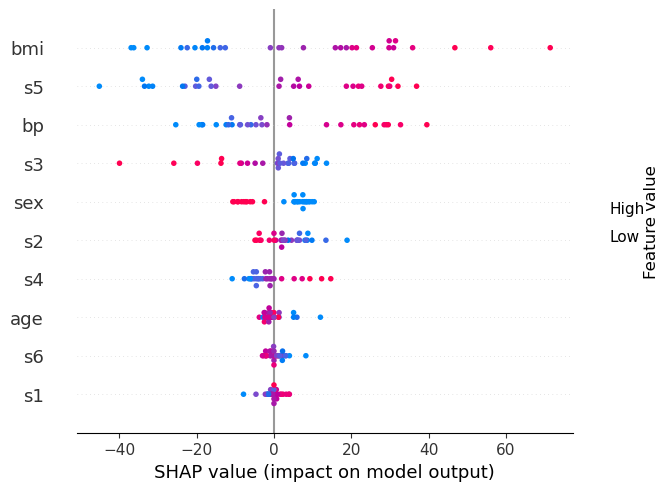

In [11]:
shap.summary_plot(shap_values, X_valid.iloc[0:N_VAL,:])

A dependence plot can be used to visualize how the BMI influences predicted outcomes.

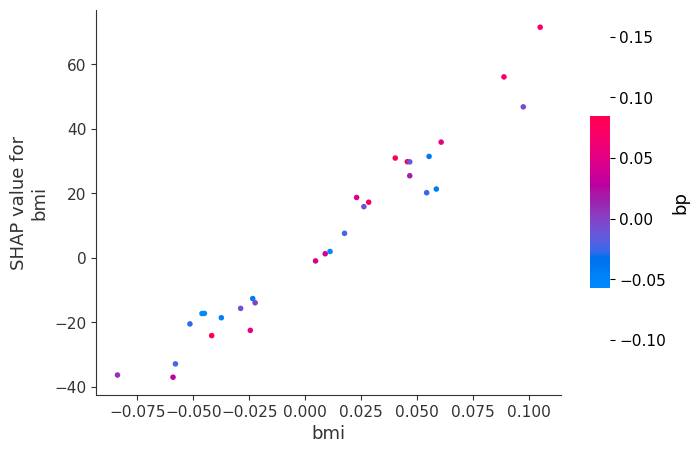

In [12]:
shap.dependence_plot("bmi", shap_values, X_valid.iloc[0:N_VAL,:])

## Scoring Overall Feature Importance via Permutation Shuffling

Note that if you'd like to understand how much each feature contributes to AutoGluon's general predictive accuracy (rather than explaining individual predictions), AutoGluon offers a built-in method for this based on [permutation-shuffling](https://explained.ai/rf-importance/):

In [13]:
val_data[label] = y_valid  # add labels to validation DataFrame
predictor.feature_importance(val_data)

Computing feature importance via permutation shuffling for 10 features using 89 rows with 5 shuffle sets...
	1.78s	= Expected runtime (0.36s per shuffle set)
	0.26s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
s5,7.376867,2.403407,0.001180,5,12.325515,2.428219
bmi,6.950714,2.967112,0.003174,5,13.060040,0.841389
bp,5.857682,2.240543,0.002135,5,10.470992,1.244372
sex,1.969329,0.620970,0.001044,5,3.247915,0.690743
s3,1.165959,1.373934,0.065301,5,3.994908,-1.662991
s4,0.772618,0.542012,0.016649,5,1.888629,-0.343394
age,0.528994,0.573717,0.054118,5,1.710285,-0.652298
s6,0.238114,0.606030,0.214622,5,1.485939,-1.009710
s1,0.083328,0.230954,0.232518,5,0.558866,-0.392211
s2,-0.339339,0.846665,0.789598,5,1.403957,-2.082634


Features with near zero or negative importance score above hardly contribute at all to AutoGluon's overall accuracy on the validation data, whereas features near the top of this list contain the most predictive signal.